<a href="https://colab.research.google.com/github/ptx-pluto/colab-notebooks/blob/master/drake_rnw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake.
if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='c1bdae733682f8a390f848bc6cb0dbbf9ea98602', drake_version='0.25.0', drake_build='releases')

from manipulation import running_as_notebook

In [ ]:
import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogOutput
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem
from pydrake.systems.framework import BasicVector, LeafSystem
import numpy as np
import dill
dill.settings['recurse'] = True

### Passive Rocking

Copy the `rnw_model` file generated by the other notebook to current directory.

In [ ]:
class FixApexRnwSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        self.rnw_model = dill.load(open("rnw_model", "rb"))
        self.M_left = self.rnw_model['M_left']
        self.M_right = self.rnw_model['M_right']
        self.cone_r = 0.35
        self.cone_m = 1.8
        self.cone_g = 9.8
        self.cone_xCP = 0.35
        self.cone_zCP = 1.5
        self.cone_xCM = 0.15
        self.cone_zCM = 0.29

        self.DeclareContinuousState(10) # One state variable.
        self.DeclareVectorOutputPort("x", BasicVector(10), self.CopyStateOut) # One output.

    def EoM(self,x):
      q = x[:5].reshape((5,1))
      #print(q.T)
      dq = x[5:10].reshape((5,1))
      ml = self.M_left( q, self.cone_r, self.cone_m, self.cone_g, self.cone_xCM, self.cone_zCM, self.cone_xCP, self.cone_zCP )
      mr = self.M_right( q, dq, self.cone_r, self.cone_m, self.cone_g, self.cone_xCM, self.cone_zCM, self.cone_xCP, self.cone_zCP )
      sol = np.linalg.solve(ml,mr)
      ddq = sol[:5]
      #print(ddq.T)
      return np.concatenate([dq,ddq])

    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().CopyToVector()
        xdot = self.EoM(x)
        derivatives.get_mutable_vector().SetFromVector(xdot)

    # y = x
    def CopyStateOut(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        output.SetFromVector(x)

In [ ]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(FixApexRnwSystem())
logger = LogOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState([0,0,0,np.pi/4,np.pi/4,0,0,0,0,0])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
#simulator.get_integrator().set_target_accuracy(0.000001)

simulator.AdvanceTo(10)

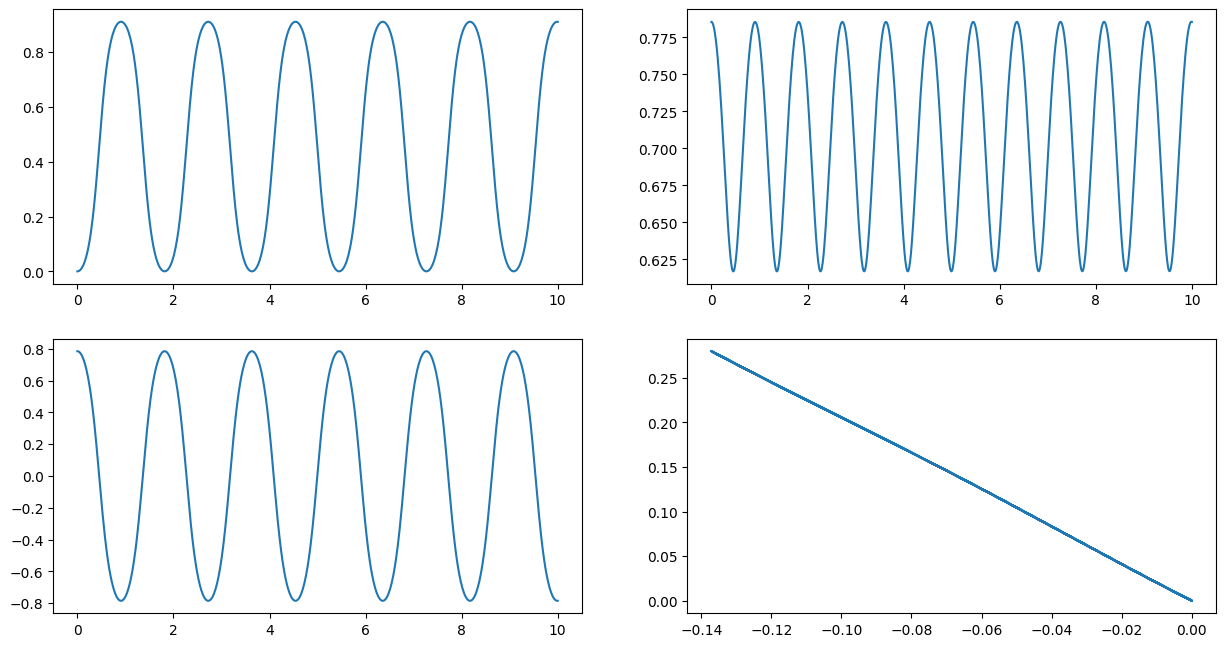

In [ ]:
import numpy as np

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100

dat = logger.data()
vt = logger.sample_times()
x     = dat[0,:]
y     = dat[1,:]
psi   = dat[2,:]
theta = dat[3,:]
phi   = dat[4,:]

fig, axs = plt.subplots(2, 2)
axs[0,0].plot(vt,psi)
axs[0,1].plot(vt,theta)
axs[1,0].plot(vt,phi)
axs[1,1].plot(x,y)